# Predicting survival on the Titanic with machine learning

Following this excellent guide:
https://www.kaggle.com/little7/titanic/titanic-data-science-solutions/notebook

Workflow:
1. Define the question or problem.
2. Get training and testing data.
3. Wrangle, prepare, and clean the data.
4. Analyze, identify patterns, and explore the data.
5. Model, predict, answer/solve the question/problem.
6. Visualize, report, and present the steps and solution.
7. Publish the results.

These steps aren't followed strictly one after the other; for instance, we'll often do some data exploration before we wrangle it as well as after.

In [323]:
# data analysis and wrangling
import pandas as pd
import numpy as np
import random as rnd

# visualization
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

# machine learning
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC, LinearSVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.linear_model import Perceptron, SGDClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import GridSearchCV, StratifiedKFold

# deep learning
import tensorflow as tf
from keras.models import Sequential
from keras.optimizers import SGD, RMSprop
from keras.layers import Dense, Activation, Dropout

## Fetch data with Pandas

In [324]:
train_df = pd.read_csv('./input/train.csv')
test_df = pd.read_csv('./input/test.csv')
combine = [train_df, test_df]

### Explore the data
What can we find out about the data we have? What might help us build a great classifier?

**Available features**

In [325]:
print(train_df.columns.values)

['PassengerId' 'Survived' 'Pclass' 'Name' 'Sex' 'Age' 'SibSp' 'Parch'
 'Ticket' 'Fare' 'Cabin' 'Embarked']


**Preview data**

In [326]:
train_df.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


In [327]:
train_df.tail()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
886,887,0,2,"Montvila, Rev. Juozas",male,27.0,0,0,211536,13.00,NaN,S
887,888,1,1,"Graham, Miss. Margaret Edith",female,19.0,0,0,112053,30.00,B42,S
888,889,0,3,"Johnston, Miss. Catherine Helen ""Carrie""",female,NaN,1,2,W./C. 6607,23.45,NaN,S
889,890,1,1,"Behr, Mr. Karl Howell",male,26.0,0,0,111369,30.00,C148,C
890,891,0,3,"Dooley, Mr. Patrick",male,32.0,0,0,370376,7.75,NaN,Q


In [328]:
train_df.info()
print('_'*40)
test_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 12 columns):
PassengerId    891 non-null int64
Survived       891 non-null int64
Pclass         891 non-null int64
Name           891 non-null object
Sex            891 non-null object
Age            714 non-null float64
SibSp          891 non-null int64
Parch          891 non-null int64
Ticket         891 non-null object
Fare           891 non-null float64
Cabin          204 non-null object
Embarked       889 non-null object
dtypes: float64(2), int64(5), object(5)
memory usage: 83.6+ KB
________________________________________
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 418 entries, 0 to 417
Data columns (total 11 columns):
PassengerId    418 non-null int64
Pclass         418 non-null int64
Name           418 non-null object
Sex            418 non-null object
Age            332 non-null float64
SibSp          418 non-null int64
Parch          418 non-null int64
Ticket         418 non-null

In [329]:
train_df.describe()

,PassengerId,Survived,Pclass,Age,SibSp,Parch,Fare
count,891.000000,891.000000,891.000000,714.000000,891.000000,891.000000,891.000000
mean,446.000000,0.383838,2.308642,29.699118,0.523008,0.381594,32.204208
std,257.353842,0.486592,0.836071,14.526497,1.102743,0.806057,49.693429
min,1.000000,0.000000,1.000000,0.420000,0.000000,0.000000,0.000000
25%,223.500000,0.000000,2.000000,20.125000,0.000000,0.000000,7.910400
50%,446.000000,0.000000,3.000000,28.000000,0.000000,0.000000,14.454200
75%,668.500000,1.000000,3.000000,38.000000,1.000000,0.000000,31.000000
max,891.000000,1.000000,3.000000,80.000000,8.000000,6.000000,512.329200


### Analyze by pivoting features

In [330]:
train_df[['Pclass', 'Survived']].groupby(['Pclass'], as_index=False).mean().sort_values(by='Survived', ascending=False)

,Pclass,Survived
0,1,0.629630
1,2,0.472826
2,3,0.242363


In [331]:
train_df[['Sex', 'Survived']].groupby(['Sex'], as_index=False).mean().sort_values(by='Survived', ascending=False)

,Sex,Survived
0,female,0.742038
1,male,0.188908


In [332]:
train_df[['SibSp', 'Survived']].groupby(['SibSp'], as_index=False).mean().sort_values(by='Survived', ascending=False)

,SibSp,Survived
1,1,0.535885
2,2,0.464286
0,0,0.345395
3,3,0.250000
4,4,0.166667
5,5,0.000000
6,8,0.000000


In [333]:
train_df[['Parch', 'Survived']].groupby(['Parch'], as_index=False).mean().sort_values(by='Survived', ascending=False)

,Parch,Survived
3,3,0.600000
1,1,0.550847
2,2,0.500000
0,0,0.343658
5,5,0.200000
4,4,0.000000
6,6,0.000000


**What'd we learn by pivoting data?**
Pclass appears highly correlated with survival rate, as does Sex. SibSp and Parch could be, but they might just  be correlated with something like Pclass.

### Analyze by visualizing data

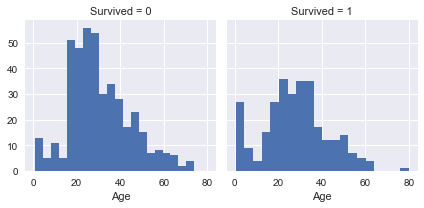

In [334]:
g = sns.FacetGrid(train_df, col='Survived')
g.map(plt.hist, 'Age', bins=20)

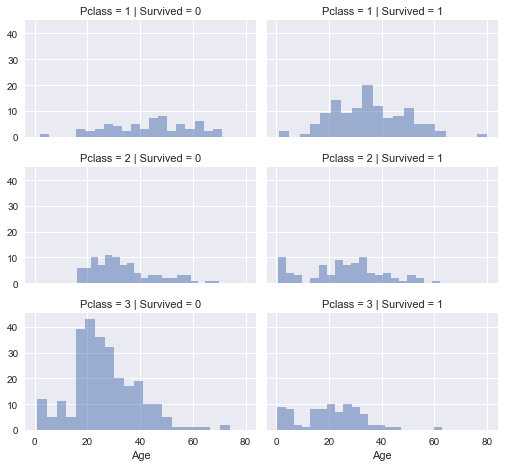

In [335]:
# grid = sns.FacetGrid(train_df, col='Pclass', hue='Survived')
grid = sns.FacetGrid(train_df, col='Survived', row='Pclass', size=2.2, aspect=1.6)
grid.map(plt.hist, 'Age', alpha=.5, bins=20)
grid.add_legend()

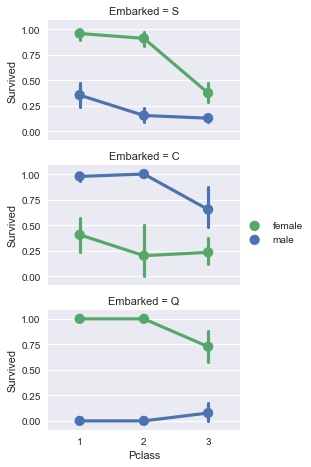

In [336]:
grid = sns.FacetGrid(train_df, row='Embarked', size=2.2, aspect=1.6)
grid.map(sns.pointplot, 'Pclass', 'Survived', 'Sex', palette='deep')
grid.add_legend()

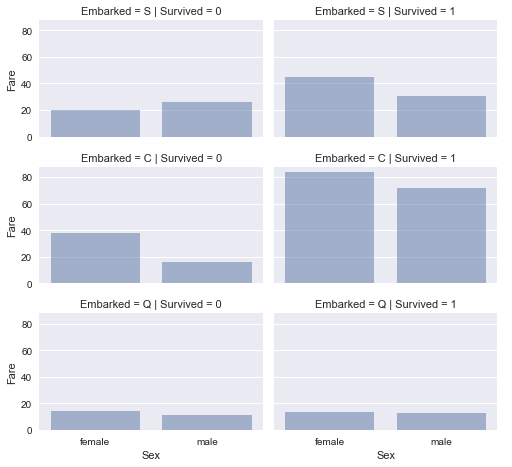

In [337]:
# grid = sns.FacetGrid(train_df, col='Embarked', hue='Survived', palette={0: 'k', 1: 'w'})
grid = sns.FacetGrid(train_df, row='Embarked', col='Survived', size=2.2, aspect=1.6)
grid.map(sns.barplot, 'Sex', 'Fare', alpha=.5, ci=None)
grid.add_legend()

## Data wrangling

We've done some exploring, and now we know a little bit more about the data we're working with and how we might be able to manipulate it to solve our problem.

**Dropping features**

There are a few features that don't appear to help us understand a passenger's change of survival at all, like Cabin and Ticket. Dropping weak features like these improves the performance of our code, and makes it easier to navigate and reason about the data.

In [338]:
print("Before shapes: ", train_df.shape, test_df.shape, combine[0].shape, combine[1].shape)

train_df = train_df.drop(['Ticket', 'Cabin'], axis=1)
test_df = test_df.drop(['Ticket', 'Cabin'], axis=1)
combine = [train_df, test_df]

print("After shapes: ", train_df.shape, test_df.shape, combine[0].shape, combine[1].shape)

Before shapes:  (891, 12) (418, 11) (891, 12) (418, 11)
After shapes:  (891, 10) (418, 9) (891, 10) (418, 9)


**Creating new features from existing ones**

Some features aren't that helpful by themselves, like Name, but may be able to be reworked into something useful. We're gonna extract a new feature, Title, from Name and see if it looks like it might be helpful.

In [339]:
for dataset in combine:
    dataset['Title'] = dataset.Name.str.extract(' ([A-Za-z]+)\.', expand=False)
    
pd.crosstab(train_df['Title'], train_df['Sex'])

Sex,female,male
Title,,
Capt,0,1
Col,0,2
Countess,1,0
Don,0,1
Dr,1,6
Jonkheer,0,1
Lady,1,0
Major,0,2
Master,0,40


Too many titles to be useful. Let's combine some of them.

In [340]:
for dataset in combine:
    dataset['Title'] = dataset['Title'].replace(['Lady', 'Countess', 'Capt', 'Col', 'Don', 'Dr', 'Major', 'Rev', 'Sir', 'Jonkheer', 'Dona'], 'Rare')
    dataset['Title'] = dataset['Title'].replace(['Mlle', 'Ms'], 'Miss')
    dataset['Title'] = dataset['Title'].replace('Mme', 'Mrs')
    
train_df[['Title', 'Survived']].groupby(['Title'], as_index=False).mean()

,Title,Survived
0,Master,0.575000
1,Miss,0.702703
2,Mr,0.156673
3,Mrs,0.793651
4,Rare,0.347826


Converting these titles from categorical to ordinal smooths things out for us down the road.

In [341]:
title_mapping = {'Mr': 1, 'Miss': 2, 'Mrs': 3, 'Master': 4, 'Rare': 5}
for dataset in combine:
    dataset['Title'] = dataset['Title'].map(title_mapping)
    dataset['Title'] = dataset['Title'].fillna(0)
    
train_df.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Fare,Embarked,Title
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,7.2500,S,1
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,71.2833,C,3
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,7.9250,S,2
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,53.1000,S,3
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,8.0500,S,1


We've extracted the useful piece from the Name feature, now we can drop it. The training dataset does not need the PassengerId feature either, so we'll drop that too.

In [342]:
train_df = train_df.drop(['Name', 'PassengerId'], axis=1)
test_df = test_df.drop(['Name'], axis=1)
combine = [train_df, test_df]

train_df.shape, test_df.shape

((891, 9), (418, 9))

**Converting categorical features**

Features containing strings should be converted to numerical values for easier computing.

In [343]:
for dataset in combine:
    dataset['Sex'] = dataset['Sex'].map({'female': 1, 'male': 0}).astype(int)
    
train_df.head()

,Survived,Pclass,Sex,Age,SibSp,Parch,Fare,Embarked,Title
0,0,3,0,22.0,1,0,7.2500,S,1
1,1,1,1,38.0,1,0,71.2833,C,3
2,1,3,1,26.0,0,0,7.9250,S,2
3,1,1,1,35.0,1,0,53.1000,S,3
4,0,3,0,35.0,0,0,8.0500,S,1


**Completing a numerical continuous feature**

Features with missing or null values should have those values estimated and completed. We'll do this for Age. To minimize the random noise introduced into our model, we'll find the median Age for each Sex/Pclass pair and use that.

In [344]:
median_ages = np.zeros((2,3))
median_ages

array([[ 0.,  0.,  0.],
       [ 0.,  0.,  0.]])

In [345]:
for dataset in combine:
    for i in range(0,2):
        for j in range(0,3):
            median_df = dataset[(dataset['Sex'] == i) & (dataset['Pclass'] == j+1)]['Age'].dropna()
            median_age = median_df.median()
            median_ages[i,j] = int(median_age/0.5 + 0.5) * 0.5
        
    for i in range(0,2):
        for j in range(0,3):
            dataset.loc[(dataset.Age.isnull()) & (dataset.Sex == i) & (dataset.Pclass == j+1), 'Age'] = median_ages[i,j]
            
    dataset['Age'] = dataset['Age'].astype(int)
    
train_df.head()

,Survived,Pclass,Sex,Age,SibSp,Parch,Fare,Embarked,Title
0,0,3,0,22,1,0,7.2500,S,1
1,1,1,1,38,1,0,71.2833,C,3
2,1,3,1,26,0,0,7.9250,S,2
3,1,1,1,35,1,0,53.1000,S,3
4,0,3,0,35,0,0,8.0500,S,1


Instead of using raw Age values to find a relationship with Survival, let's create some bands.

In [346]:
train_df['AgeBand'] = pd.cut(train_df['Age'], 6)
train_df[['AgeBand', 'Survived']].groupby(['AgeBand'], as_index=False).mean().sort_values(by='AgeBand', ascending=True)

,AgeBand,Survived
0,"(-0.08, 13.333]",0.591549
1,"(13.333, 26.667]",0.317708
2,"(26.667, 40]",0.427083
3,"(40, 53.333]",0.397959
4,"(53.333, 66.667]",0.348837
5,"(66.667, 80]",0.142857


Now we replace Age values with ordinals based on the above bands.

In [347]:
for dataset in combine:
    dataset.loc[dataset['Age'] <= 13.33, 'Age'] = 0
    dataset.loc[(dataset['Age'] > 13.33) & (dataset['Age'] <= 26.67), 'Age'] = 1
    dataset.loc[(dataset['Age'] > 26.67) & (dataset['Age'] <= 40), 'Age'] = 2
    dataset.loc[(dataset['Age'] > 40) & (dataset['Age'] <= 53.33), 'Age'] = 3
    dataset.loc[(dataset['Age'] > 53.33) & (dataset['Age'] <= 66.67), 'Age'] = 4
    dataset.loc[dataset['Age'] > 66.67, 'Age'] = 5

train_df.head()

,Survived,Pclass,Sex,Age,SibSp,Parch,Fare,Embarked,Title,AgeBand
0,0,3,0,1,1,0,7.2500,S,1,"(13.333, 26.667]"
1,1,1,1,2,1,0,71.2833,C,3,"(26.667, 40]"
2,1,3,1,1,0,0,7.9250,S,2,"(13.333, 26.667]"
3,1,1,1,2,1,0,53.1000,S,3,"(26.667, 40]"
4,0,3,0,2,0,0,8.0500,S,1,"(26.667, 40]"


Now that we've reworked Age according to AgeBand, we can drop AgeBand.

In [348]:
train_df = train_df.drop(['AgeBand'], axis=1)
combine = [train_df, test_df]
train_df.head()

,Survived,Pclass,Sex,Age,SibSp,Parch,Fare,Embarked,Title
0,0,3,0,1,1,0,7.2500,S,1
1,1,1,1,2,1,0,71.2833,C,3
2,1,3,1,1,0,0,7.9250,S,2
3,1,1,1,2,1,0,53.1000,S,3
4,0,3,0,2,0,0,8.0500,S,1


**Create new features by combining existing features**

Let's put Parch and SibSp together to make FamilySize.

In [349]:
for dataset in combine:
    dataset['FamilySize'] = dataset['SibSp'] + dataset['Parch'] + 1
    
train_df[['FamilySize', 'Survived']].groupby(['FamilySize'], as_index=False).mean().sort_values(by='Survived', ascending=False)

,FamilySize,Survived
3,4,0.724138
2,3,0.578431
1,2,0.552795
6,7,0.333333
0,1,0.303538
4,5,0.200000
5,6,0.136364
7,8,0.000000
8,11,0.000000


We'll opt instead for a new feature called IsAlone.

In [350]:
for dataset in combine:
    dataset['IsAlone'] = 0
    dataset.loc[dataset['FamilySize'] == 1, 'IsAlone'] = 1
    
train_df[['IsAlone', 'Survived']].groupby(['IsAlone'], as_index=False).mean()

,IsAlone,Survived
0,0,0.505650
1,1,0.303538


Looks like IsAlone is a better feature. We'll drop SibSp, Parch, and FamilySize now that we've got it.

In [351]:
train_df = train_df.drop(['Parch', 'SibSp', 'FamilySize'], axis=1)
test_df = test_df.drop(['Parch', 'SibSp', 'FamilySize'], axis=1)
combine = [train_df, test_df]

train_df.head()

,Survived,Pclass,Sex,Age,Fare,Embarked,Title,IsAlone
0,0,3,0,1,7.2500,S,1,0
1,1,1,1,2,71.2833,C,3,0
2,1,3,1,1,7.9250,S,2,1
3,1,1,1,2,53.1000,S,3,0
4,0,3,0,2,8.0500,S,1,1


Apparently Age times Pclass is a good artificial feature too, so let's make that.

In [352]:
for dataset in combine:
    dataset['Age*Class'] = dataset.Age * dataset.Pclass
    
train_df.loc[:, ['Age*Class', 'Age', 'Pclass']].head(10)

,Age*Class,Age,Pclass
0,3,1,3
1,2,2,1
2,3,1,3
3,2,2,1
4,6,2,3
5,3,1,3
6,4,4,1
7,0,0,3
8,6,2,3
9,2,1,2


**Completing a categorical feature**

Embarked is missing two values, so we'll fill those in with the most common occurrence of Embarked.

In [353]:
common_port = train_df.Embarked.dropna().mode()[0]
common_port

'S'

In [354]:
for dataset in combine:
    dataset['Embarked'] = dataset['Embarked'].fillna(common_port)
    
train_df[['Embarked', 'Survived']].groupby(['Embarked'], as_index=False).mean().sort_values(by='Survived', ascending=False)

,Embarked,Survived
0,C,0.553571
1,Q,0.389610
2,S,0.339009


Looks great. Now let's convert this categorical feature into a numeric one.

In [355]:
for dataset in combine:
    dataset['Embarked'] = dataset['Embarked'].map({'S': 0, 'C': 1, 'Q': 2}).astype(int)
    
train_df.head()

,Survived,Pclass,Sex,Age,Fare,Embarked,Title,IsAlone,Age*Class
0,0,3,0,1,7.2500,0,1,0,3
1,1,1,1,2,71.2833,1,3,0,2
2,1,3,1,1,7.9250,0,2,1,3
3,1,1,1,2,53.1000,0,3,0,2
4,0,3,0,2,8.0500,0,1,1,6


One final feature that needs wrangling: Fare. There's one missing value, so we'll use the median of available Fare data. Then we'll create a FareBand and use that to convert Fare numeric values into ordinal ones.

In [356]:
test_df['Fare'].fillna(test_df['Fare'].dropna().median(), inplace=True)
test_df.head()

,PassengerId,Pclass,Sex,Age,Fare,Embarked,Title,IsAlone,Age*Class
0,892,3,0,2,7.8292,2,1,1,6
1,893,3,1,3,7.0000,0,3,0,9
2,894,2,0,4,9.6875,2,1,1,8
3,895,3,0,2,8.6625,0,1,1,6
4,896,3,1,1,12.2875,0,3,0,3


In [357]:
train_df['FareBand'] = pd.qcut(train_df['Fare'], 4)
train_df[['FareBand', 'Survived']].groupby(['FareBand'], as_index=False).mean().sort_values(by='FareBand', ascending=True)

,FareBand,Survived
0,"[0, 7.91]",0.197309
1,"(7.91, 14.454]",0.303571
2,"(14.454, 31]",0.454955
3,"(31, 512.329]",0.581081


In [358]:
for dataset in combine:
    dataset.loc[dataset['Fare'] <= 7.91, 'Fare'] = 0
    dataset.loc[(dataset['Fare'] > 7.91) & (dataset['Fare'] <= 14.454), 'Fare'] = 1
    dataset.loc[(dataset['Fare'] > 14.454) & (dataset['Fare'] <= 31), 'Fare'] = 2
    dataset.loc[dataset['Fare'] > 31, 'Fare'] = 3
    dataset['Fare'] = dataset['Fare'].astype(int)
    
train_df = train_df.drop(['FareBand'], axis=1)
combine = [train_df, test_df]

train_df.head(10)

,Survived,Pclass,Sex,Age,Fare,Embarked,Title,IsAlone,Age*Class
0,0,3,0,1,0,0,1,0,3
1,1,1,1,2,3,1,3,0,2
2,1,3,1,1,1,0,2,1,3
3,1,1,1,2,3,0,3,0,2
4,0,3,0,2,1,0,1,1,6
5,0,3,0,1,1,2,1,1,3
6,0,1,0,4,3,0,1,1,4
7,0,3,0,0,2,0,4,0,0
8,1,3,1,2,1,0,3,0,6
9,1,2,1,1,2,1,3,0,2


In [359]:
test_df.head(10)

,PassengerId,Pclass,Sex,Age,Fare,Embarked,Title,IsAlone,Age*Class
0,892,3,0,2,0,2,1,1,6
1,893,3,1,3,0,0,3,0,9
2,894,2,0,4,1,2,1,1,8
3,895,3,0,2,1,0,1,1,6
4,896,3,1,1,1,0,3,0,3
5,897,3,0,1,1,0,1,1,3
6,898,3,1,2,0,2,2,1,6
7,899,2,0,1,2,0,1,0,2
8,900,3,1,1,0,1,3,1,3
9,901,3,0,1,2,0,1,0,3


## Model, predict, and solve

Our data looks excellent! 100% safe to feed to our models, and that's just what we're going to do.

In [360]:
X_train = train_df.drop('Survived', axis=1)
Y_train = train_df['Survived']
X_test = test_df.drop('PassengerId', axis=1).copy()
X_train.shape, Y_train.shape, X_test.shape

((891, 8), (891,), (418, 8))

In [361]:
# Logistic Regression

logreg = LogisticRegression()
logreg.fit(X_train, Y_train)
Y_pred_logreg = logreg.predict(X_test)
acc_log = round(logreg.score(X_train, Y_train) * 100, 2)
acc_log

80.700000000000003

What features does the model think are important?

In [362]:
coeff_df = pd.DataFrame(train_df.columns.delete(0))
coeff_df.columns = ['Feature']
coeff_df['Correlation'] = pd.Series(logreg.coef_[0])

coeff_df.sort_values(by='Correlation', ascending=False)

,Feature,Correlation
1,Sex,2.183729
5,Title,0.423748
4,Embarked,0.276608
6,IsAlone,0.268260
7,Age*Class,0.020133
3,Fare,0.008420
2,Age,-0.423741
0,Pclass,-1.169712


In [363]:
# Support Vector Machines

params = [{
    'kernel': ['rbf', 'linear'],
    'C': [1, 5, 10, 25, 50, 100, 250, 500, 1000]
}]
svc = SVC()
clf = GridSearchCV(svc, params)
clf.fit(X_train, Y_train)
print("Best parameters: {}".format(clf.best_params_))
Y_pred_svc = clf.predict(X_test)
acc_svc = round(clf.score(X_train, Y_train) * 100, 2)
acc_svc

Best parameters: {'C': 5, 'kernel': 'rbf'}


85.189999999999998

In [364]:
# K-Nearest Neighbors

params = [{
    'n_neighbors': range(2,20,2),
    'weights': ['uniform', 'distance'],
    'algorithm': ['auto', 'ball_tree', 'kd_tree', 'brute']
}]
knn = KNeighborsClassifier()
clf = GridSearchCV(knn, params)
clf.fit(X_train, Y_train)
print("Best parameters: {}".format(clf.best_params_))
Y_pred_knn = clf.predict(X_test)
acc_knn = round(clf.score(X_train, Y_train) * 100, 2)
acc_knn

Best parameters: {'algorithm': 'auto', 'n_neighbors': 14, 'weights': 'uniform'}


82.489999999999995

In [365]:
# Gaussian Naive Bayes

gaussian = GaussianNB()
gaussian.fit(X_train, Y_train)
Y_pred_gaussian = gaussian.predict(X_test)
acc_gaussian = round(gaussian.score(X_train, Y_train) * 100, 2)
acc_gaussian

77.670000000000002

In [366]:
# Perceptron

perceptron = Perceptron()
perceptron.fit(X_train, Y_train)
Y_pred_perceptron = perceptron.predict(X_test)
acc_perceptron = round(perceptron.score(X_train, Y_train) * 100, 2)
acc_perceptron

80.579999999999998

In [367]:
# Linear SVC

linear_svc = LinearSVC()
linear_svc.fit(X_train, Y_train)
Y_pred_linear_svc = linear_svc.predict(X_test)
acc_linear_svc = round(linear_svc.score(X_train, Y_train) * 100, 2)
acc_linear_svc

79.569999999999993

In [368]:
# Stochastic Gradient Descent

params = [{
    'loss': ['hinge', 'log', 'modified_huber', 'squared_hinge'],
    'penalty': ['none', 'l2', 'l1', 'elasticnet']
}]
sgd = SGDClassifier()
clf = GridSearchCV(sgd, params)
clf.fit(X_train, Y_train)
print("Best parameters: {}".format(clf.best_params_))
Y_pred_sgd = clf.predict(X_test)
acc_sgd = round(clf.score(X_train, Y_train) * 100, 2)
acc_sgd

Best parameters: {'loss': 'log', 'penalty': 'l1'}


40.520000000000003

In [369]:
# Decision Tree

params = [{
    'criterion': ['gini', 'entropy'],
    'splitter': ['best', 'random'],
    'max_features': [None, 'auto', 'log2'],
    'min_samples_split': range(2,20,2)
}]
decision_tree = DecisionTreeClassifier()
clf = GridSearchCV(decision_tree, params)
clf.fit(X_train, Y_train)
print("Best parameters: {}".format(clf.best_params_))
Y_pred_decision_tree = clf.predict(X_test)
acc_decision_tree = round(clf.score(X_train, Y_train) * 100, 2)
acc_decision_tree

Best parameters: {'criterion': 'gini', 'max_features': 'log2', 'min_samples_split': 16, 'splitter': 'random'}


84.959999999999994

In [370]:
# Random Forest

params = [{
    'n_estimators': range(1,100,5),
    'criterion': ['gini', 'entropy'],
    'min_samples_split': range(2,15)
}]
random_forest = RandomForestClassifier()
clf = GridSearchCV(random_forest, params)
clf.fit(X_train, Y_train)
print("Best parameters: {}".format(clf.best_params_))
Y_pred_random_forest = clf.predict(X_test)
acc_random_forest = round(clf.score(X_train, Y_train) * 100, 2)
acc_random_forest

Best parameters: {'criterion': 'gini', 'min_samples_split': 5, 'n_estimators': 6}


86.760000000000005

**Helper functions for our neural nets**

In [371]:
# Make performance charts
def chart_net_performance(history):
    # summarize history for accuracy
    plt.plot(history['acc'])
    plt.plot(history['val_acc'])
    plt.title('Model Accuracy')
    plt.ylabel('Accuracy')
    plt.xlabel('Epoch')
    plt.legend(['train', 'test'], loc='upper left')
    plt.show()
    # summary history for loss
    plt.plot(history['loss'])
    plt.plot(history['val_loss'])
    plt.title('Model Loss')
    plt.ylabel('Loss')
    plt.xlabel('Epoch')
    plt.legend(['train', 'test'], loc='upper left')
    plt.show()
    
# Make neural net
def gen_net(dropout):
    net = Sequential()
    net.add(Dropout(dropout, input_shape=X_train.shape[1:]))
    return net

# run that ish
def run_it(net, train, test):
    # add output layer
    net.add(Dense(1, activation='sigmoid'))
    # compile model
    net.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
    # fit the model
    history = net.fit(X_train.values[train],
                      Y_train.values[train],
                      validation_split=0.25,
                      epochs=500,
                      verbose=0)
    # evaluate the model
    scores = net.evaluate(X_train.values[test], Y_train.values[test], verbose=0)
    print(net.metrics_names[1], scores[1]*100.)
    chart_net_performance(history.history)
    return scores[1]*100.

# test a net
def test_a_net(folds, dropout, *args):
    kfold = StratifiedKFold(n_splits=folds, shuffle=True)
    scores = []
    show_summary = True
    
    for train, test in kfold.split(X_train.values, Y_train.values):
        net = gen_net(dropout)
        for arg in args:
            net.add(Dense(arg, activation='relu'))
        if show_summary:
            net.summary()
            show_summary = False
        scores.append(run_it(net, train, test))
    
    print("{0}% (+/- {1}%)".format(np.mean(scores), np.std(scores)))
    Y_pred_net = net.predict(X_test.values).ravel().round().astype(int)

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dropout_101 (Dropout)        (None, 8)                 0         
_________________________________________________________________
dense_324 (Dense)            (None, 250)               2250      
_________________________________________________________________
dense_325 (Dense)            (None, 250)               62750     
_________________________________________________________________
dense_326 (Dense)            (None, 24)                6024      
_________________________________________________________________
dense_327 (Dense)            (None, 12)                300       
Total params: 71,324.0
Trainable params: 71,324.0
Non-trainable params: 0.0
_________________________________________________________________
acc 79.3296092382


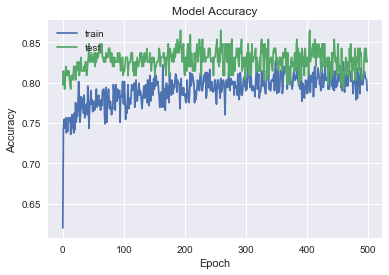

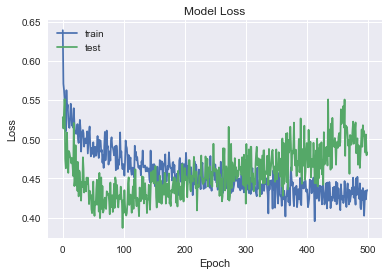

acc 85.4748603352


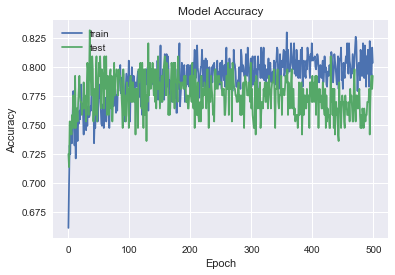

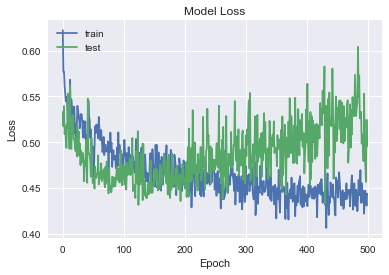

acc 78.0898877744


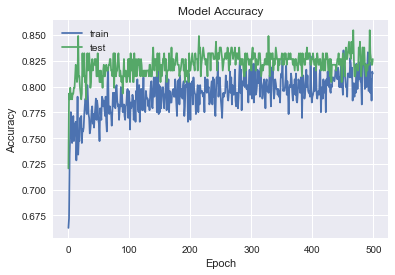

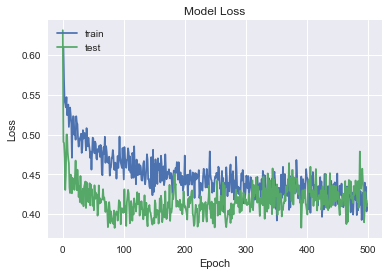

acc 80.3370784508


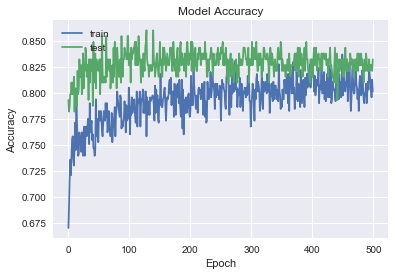

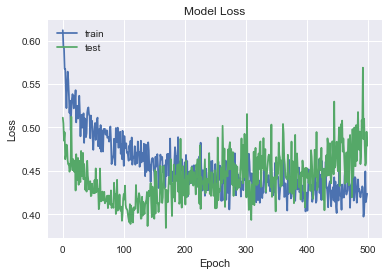

acc 77.9661018296


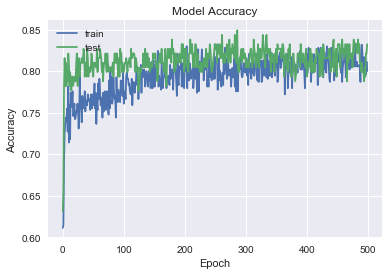

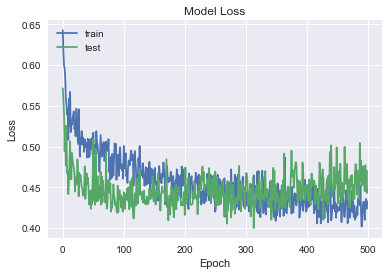

80.2395075256419% (+/- 2.7581005258346045%)


In [372]:
test_a_net(5, 0.3, 250, 250, 24, 12)

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dropout_106 (Dropout)        (None, 8)                 0         
_________________________________________________________________
dense_349 (Dense)            (None, 60)                540       
Total params: 540.0
Trainable params: 540.0
Non-trainable params: 0.0
_________________________________________________________________
acc 80.4469272744


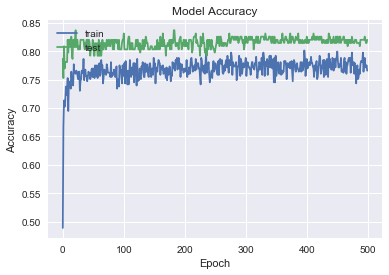

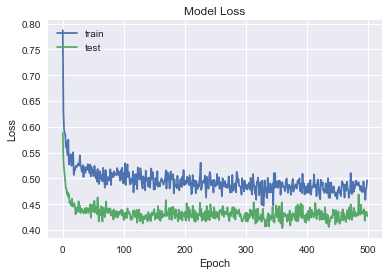

acc 82.1229050945


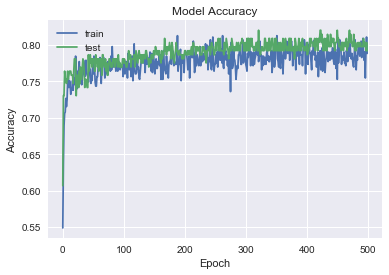

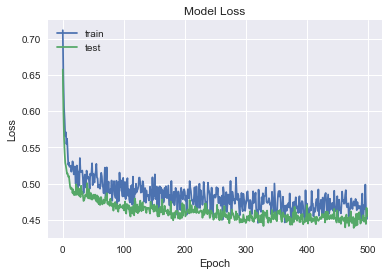

acc 80.3370787187


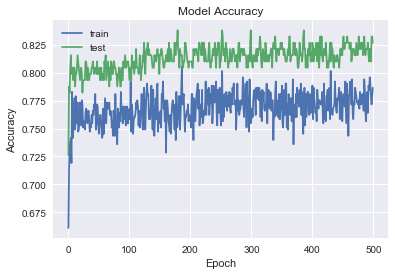

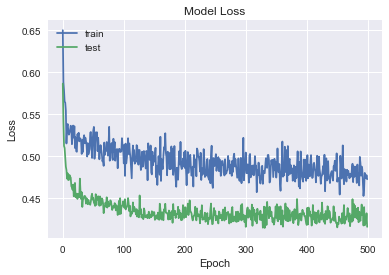

acc 83.1460672148


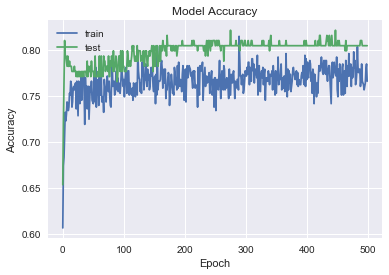

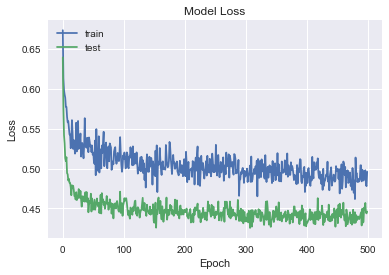

acc 78.5310735474


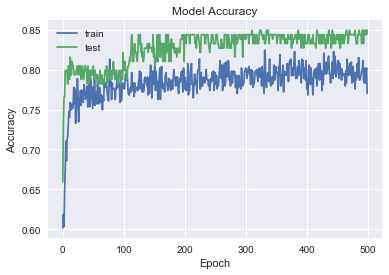

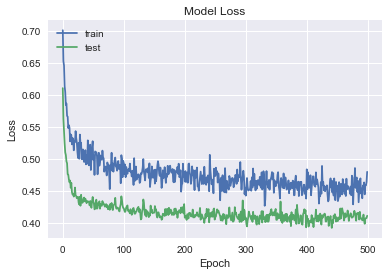

80.91681036995223% (+/- 1.5920345261789068%)


In [373]:
test_a_net(5, 0.25, 60)

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dropout_111 (Dropout)        (None, 8)                 0         
_________________________________________________________________
dense_359 (Dense)            (None, 250)               2250      
_________________________________________________________________
dense_360 (Dense)            (None, 250)               62750     
_________________________________________________________________
dense_361 (Dense)            (None, 250)               62750     
_________________________________________________________________
dense_362 (Dense)            (None, 250)               62750     
_________________________________________________________________
dense_363 (Dense)            (None, 250)               62750     
_________________________________________________________________
dense_364 (Dense)            (None, 24)                6024      
__________

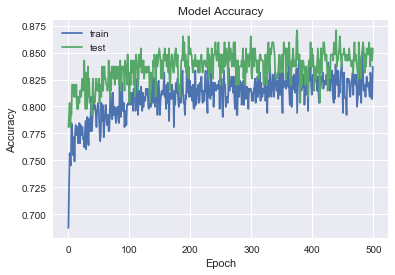

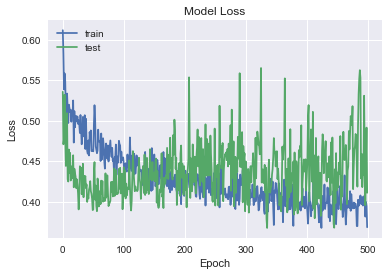

acc 80.4469275075


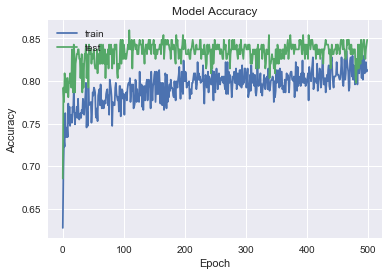

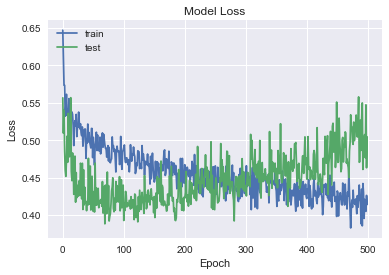

acc 76.9662918669


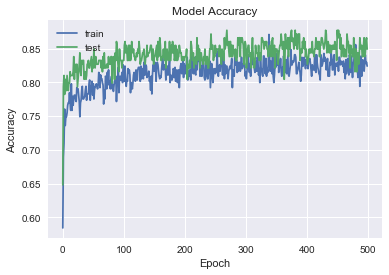

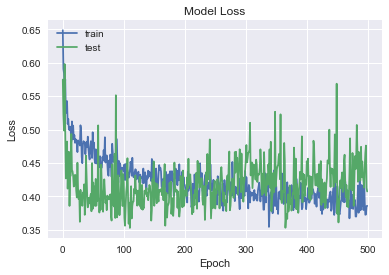

acc 76.9662922688


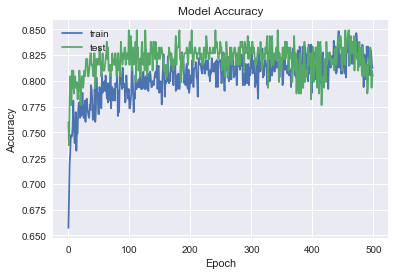

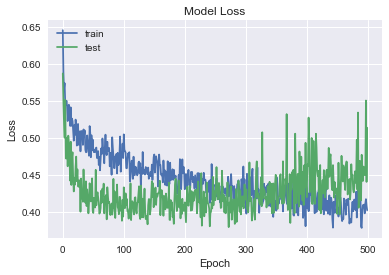

acc 84.7457627119


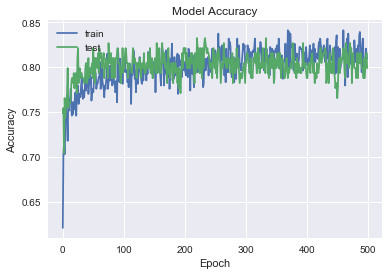

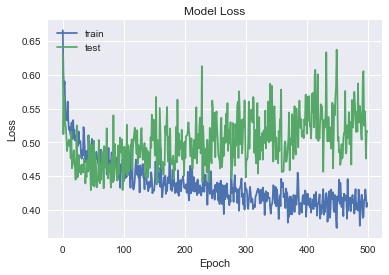

79.69097663874643% (+/- 2.8670794432505895%)


In [374]:
test_a_net(5, 0.25, 250, 250, 250, 250, 250, 24, 12)

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dropout_116 (Dropout)        (None, 8)                 0         
_________________________________________________________________
dense_399 (Dense)            (None, 512)               4608      
_________________________________________________________________
dense_400 (Dense)            (None, 512)               262656    
_________________________________________________________________
dense_401 (Dense)            (None, 256)               131328    
_________________________________________________________________
dense_402 (Dense)            (None, 64)                16448     
_________________________________________________________________
dense_403 (Dense)            (None, 16)                1040      
Total params: 416,080.0
Trainable params: 416,080.0
Non-trainable params: 0.0
________________________________________________________________

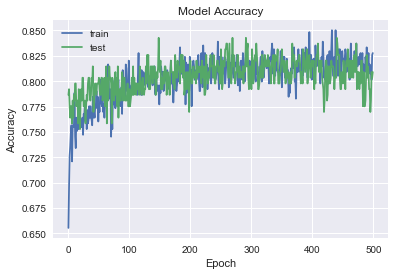

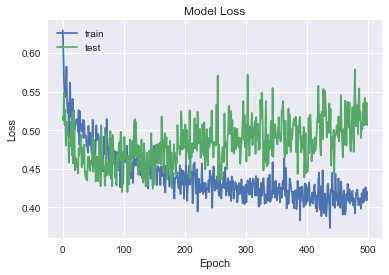

acc 81.0055864257


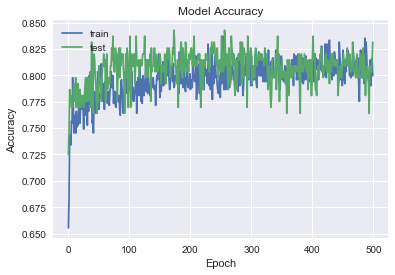

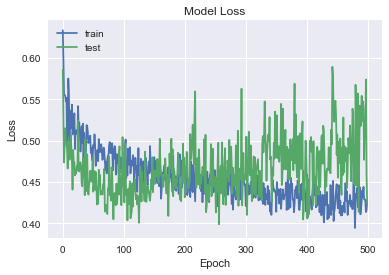

acc 78.0898879083


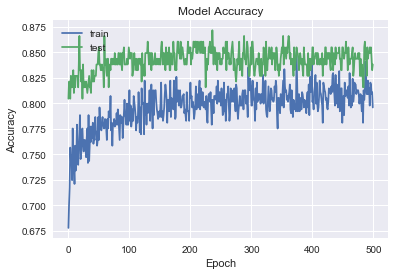

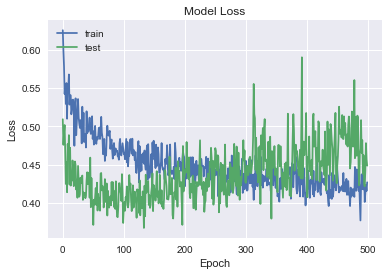

acc 78.6516851254


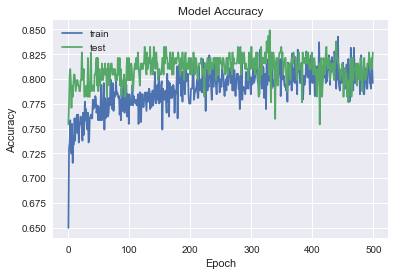

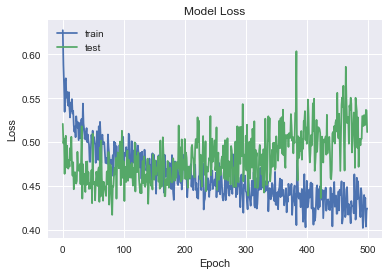

acc 82.4858758409


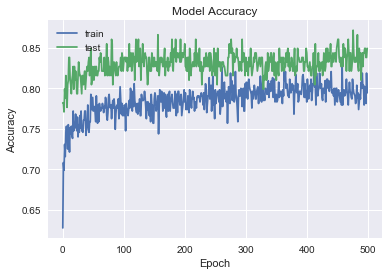

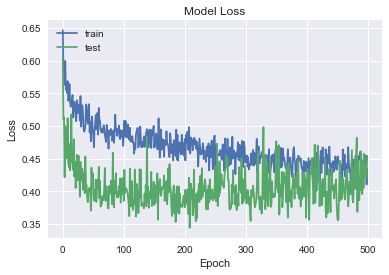

79.91252881447235% (+/- 1.6166899713209473%)


In [375]:
test_a_net(5, 0.3, 512, 512, 256, 64, 16)

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dropout_121 (Dropout)        (None, 8)                 0         
_________________________________________________________________
dense_429 (Dense)            (None, 512)               4608      
_________________________________________________________________
dense_430 (Dense)            (None, 256)               131328    
_________________________________________________________________
dense_431 (Dense)            (None, 16)                4112      
Total params: 140,048.0
Trainable params: 140,048.0
Non-trainable params: 0.0
_________________________________________________________________
acc 80.446927674


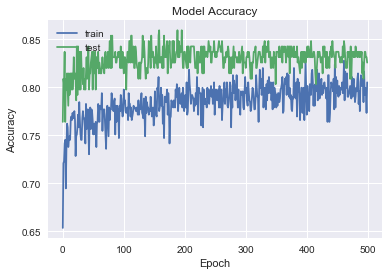

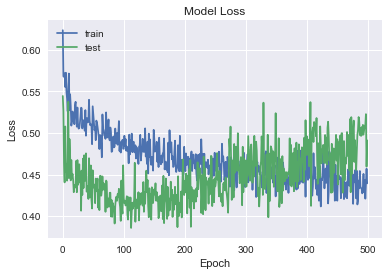

acc 83.2402233638


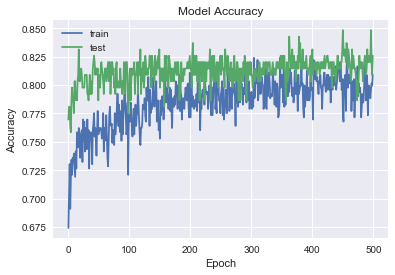

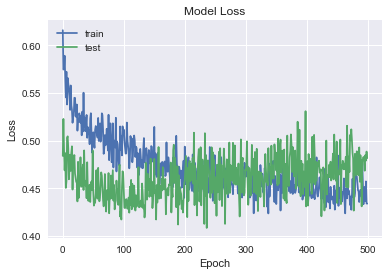

acc 74.1573031699


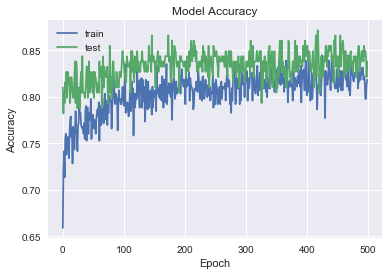

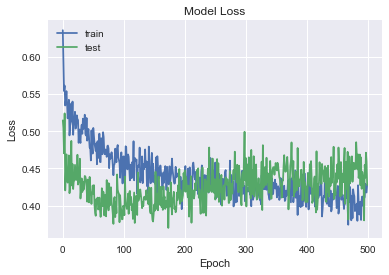

acc 80.8988764715


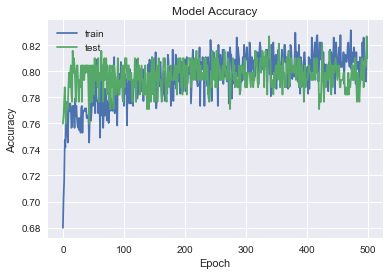

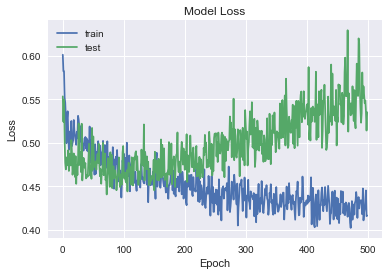

acc 80.7909604857


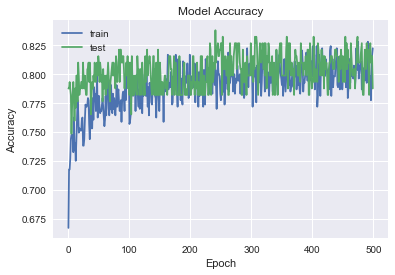

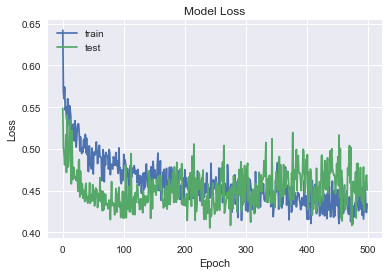

79.90685823295424% (+/- 3.040595944837131%)


In [376]:
test_a_net(5, 0.3, 512, 256, 16)

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dropout_126 (Dropout)        (None, 8)                 0         
_________________________________________________________________
dense_449 (Dense)            (None, 200)               1800      
Total params: 1,800.0
Trainable params: 1,800.0
Non-trainable params: 0.0
_________________________________________________________________
acc 80.4469272078


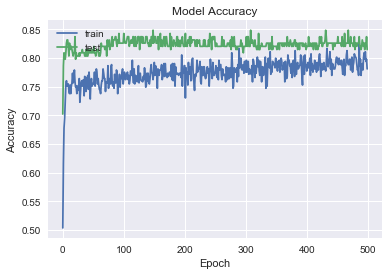

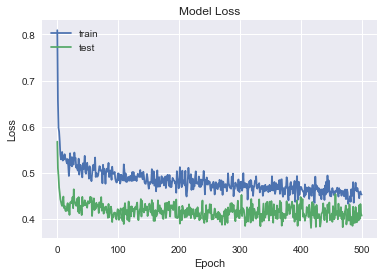

acc 81.5642457102


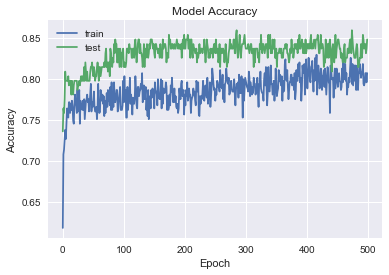

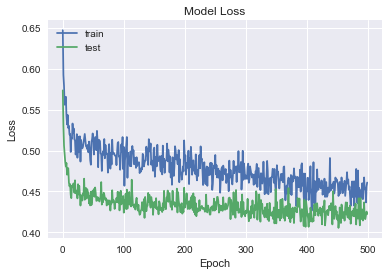

acc 75.8426967632


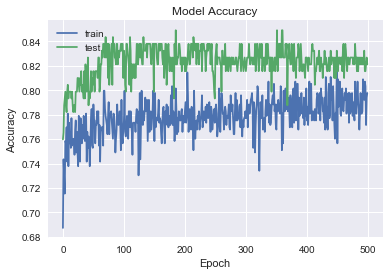

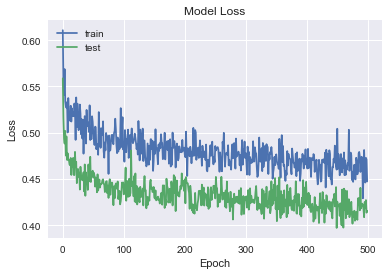

acc 85.3932584939


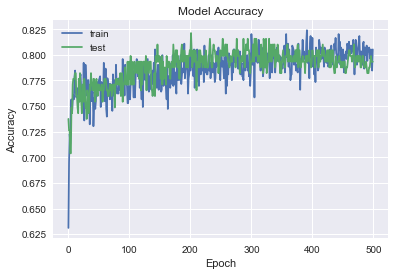

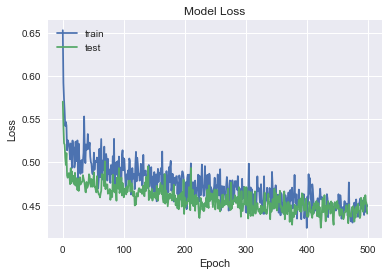

acc 75.7062148576


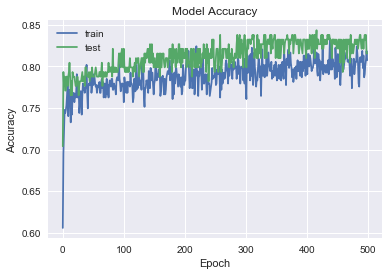

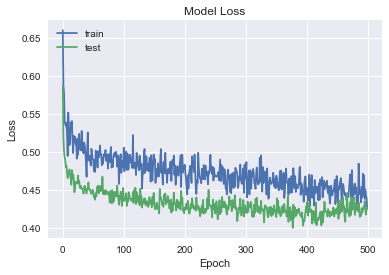

79.79066860654052% (+/- 3.6670017355775917%)


In [377]:
test_a_net(5, 0.25, 200)

In [378]:
models = pd.DataFrame({
    'Model': ['Support Vector Machines', 'KNN', 'Logistic Regression', 'Random Forest', 'Naive Bayes', 'Perceptron', 'Stochastic Gradient Descent', 'Linear SVC', 'Decision Tree', 'Neural Network'],
    'Score': [acc_svc, acc_knn, acc_log, acc_random_forest, acc_gaussian, acc_perceptron, acc_sgd, acc_linear_svc, acc_decision_tree, acc_net]
})
models.sort_values(by='Score', ascending=False)

,Model,Score
3,Random Forest,86.760000
0,Support Vector Machines,85.190000
8,Decision Tree,84.960000
1,KNN,82.490000
2,Logistic Regression,80.700000
5,Perceptron,80.580000
7,Linear SVC,79.570000
9,Neural Network,79.453597
4,Naive Bayes,77.670000
6,Stochastic Gradient Descent,40.520000


In [379]:
#1
submission = pd.DataFrame({
    'PassengerId': test_df['PassengerId'],
    'Survived': Y_pred_random_forest
})
submission.to_csv('./output/predictions_random_forest.csv', index=False)

#2
submission = pd.DataFrame({
    'PassengerId': test_df['PassengerId'],
    'Survived': Y_pred_decision_tree
})
submission.to_csv('./output/predictions_decision_tree.csv', index=False)

#3
submission = pd.DataFrame({
    'PassengerId': test_df['PassengerId'],
    'Survived': Y_pred_knn
})
submission.to_csv('./output/predictions_knn.csv', index=False)

#4
submission = pd.DataFrame({
    'PassengerId': test_df['PassengerId'],
    'Survived': Y_pred_svc
})
submission.to_csv('./output/predictions_svc.csv', index=False)

#5
submission = pd.DataFrame({
    'PassengerId': test_df['PassengerId'],
    'Survived': Y_pred_net
})
submission.to_csv('./output/predictions_net.csv', index=False)